In [59]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import cm
%matplotlib inline
from matplotlib import pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF
import datetime
from matplotlib.colors import TwoSlopeNorm
import json
import geopandas as gpd
import requests
import plotly.express as px
from shapely import wkt
import os
import geojson
import csv
import warnings

from natsort import natsorted
from PIL import Image

import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

#Avoiding Type 3 fonts in matplotlib plots
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Suppress FutureWarning messages
warnings.simplefilter(action='ignore', category=FutureWarning)

In [60]:
font = {'size'   : 20}

matplotlib.rc('font', **font)
matplotlib.rc('lines', linewidth=2.0)
matplotlib.rc('lines', markersize=8)

In [61]:
pd.set_option('display.max_rows', 500)

In [62]:
res='results_covid/' 

## RKI data reading

In [63]:
# reading input data and drop column LKNR

#this file contains the daily RKI incidence data from November 2020 to September 2021
df1=pd.read_csv('data/7-days incidences1.csv').drop(['LKNR'], axis=1)

#this file contains the daily RKI incidence data from September 2021 to October 2022
df2=pd.read_csv('data/7-days incidences2.csv').drop(['LKNR'], axis=1)

#example output
df1.head(2)

,LK,18.11.2020,19.11.2020,20.11.2020,21.11.2020,22.11.2020,23.11.2020,24.11.2020,25.11.2020,26.11.2020,...,2021/9/1,2021/9/2,2021/9/3,2021/9/4,2021/9/5,2021/9/6,2021/9/7,2021/9/8,2021/9/9,2021/9/10
0,LK Ahrweiler,143.8,156.1,159.1,156.1,172.2,139.1,139.9,136.8,119.9,...,122.7,148.8,188.0,177.0,199.3,183.4,197.2,208.7,171.8,191.8
1,LK Aichach-Friedberg,144.8,138.9,158.2,173.8,167.8,156.0,139.6,121.8,95.1,...,68.9,90.4,98.6,102.2,99.2,92.7,92.7,94.9,68.2,71.2


In [64]:
# merge two data sets
df=df1.set_index('LK').join(df2.set_index('LK'))

In [65]:
#covert to date time, specify the format
df.columns = pd.to_datetime(df.columns,format='mixed',dayfirst=True).strftime("%Y-%m-%d")

# sort the columns by date
df = df.reindex(sorted(df.columns), axis=1)

In [66]:
# Compute the average 7-days incidences per week
df_covid=df.groupby(np.arange(len(df.columns)) // 7,axis=1).mean()

# rename and set the index as a column
df_covid = df_covid.reset_index().rename(columns={"index":"LK"})
df_covid.head(2)

,LK,0,1,2,3,4,5,6,7,8,...,92,93,94,95,96,97,98,99,100,101
0,LK Ahrweiler,152.328571,117.728571,102.242857,97.414286,119.700000,98.257143,102.471429,108.485714,109.042857,...,182.471429,199.442857,252.614286,289.985714,366.100000,478.457143,600.557143,719.842857,646.042857,416.833333
1,LK Aichach-Friedberg,154.157143,143.885714,154.900000,115.942857,133.885714,120.842857,76.585714,96.642857,77.342857,...,289.828571,212.142857,219.957143,228.928571,302.271429,593.100000,962.100000,1051.457143,731.271429,456.716667


In [67]:
'''
Berlin is split into multiple districts in the RKI data
To make the data compatible with our geometrical data, we aggregate the information of all
districts and create a single county for all of Berlin
'''
# compute the data from all regions in Berlin, sum it up
SK_Berlin=df_covid[df_covid.LK.str.contains('Berlin')].sum()
# rename the row
SK_Berlin=SK_Berlin.replace(SK_Berlin.LK,'SK Berlin')
# convert from series to dataframe
SK_Berlin=pd.DataFrame([SK_Berlin.tolist()], columns=SK_Berlin.index)

#remove the original Berlin data rows
df_covid = df_covid.drop(df_covid[df_covid.LK.str.contains('Berlin')].index)

# add the new combined row into original dataframe
df_covid=pd.concat([df_covid, SK_Berlin]).reset_index(drop=True)


In [72]:
'''
Resolve mismatches manually by observation

LK Vorpommern-Greifswald in df_covid --> duplicate to LK Vorpommern-Greifswald 1
LK Vorpommern-Rügenin in df_covid --> duplicate to LK Vorpommern-Rügenin 1
'''
VG=df_covid[df_covid.LK.str.contains('Vorpommern-Greifswald')]
VR=df_covid[df_covid.LK.str.contains('Vorpommern-Rügen')]
# rename the rows
VG=VG.replace('Vorpommern-Greifswald', 'Vorpommern-Greifswald 1',regex=True)
VR=VR.replace('Vorpommern-Rügen', 'Vorpommern-Rügen 1',regex=True)

#concat all dataframes
df_covid=pd.concat([df_covid,VG,VR]).reset_index(drop=True)

## Read geo data and combine it with covid data

In [73]:
"""
Read geographical data of Germany

"geo_germay.pkl": contains geographic features for each of the counties (Landkreise and Stadtkreise) of Germany
Most notably contains a polygon that describes the border of each county that is used when drawing the map later on
"""
geo_ger=pd.read_pickle('data/geo_germany.pkl')
geo_ger.head(2)

,LK,ID_0,ISO,NAME_0,ID_1,NAME_1,ID_2,NAME_2,ID_3,NAME_3,NL_NAME_3,VARNAME_3,TYPE_3,ENGTYPE_3,geometry
0,LK Karlsruhe,86.0,DEU,Germany,1.0,Baden-Württemberg,2.0,Karlsruhe,17.0,Karlsruhe,NaN,NaN,Landkreise,Rural district,"MULTIPOLYGON (((8.53890 48.95514, 8.53952 48.9..."
1,LK Konstanz,86.0,DEU,Germany,1.0,Baden-Württemberg,1.0,Freiburg,4.0,Konstanz,NaN,Constance,Landkreise,Rural district,"MULTIPOLYGON (((8.70837 47.71556, 8.70918 47.7..."


In [74]:
# get full columns for the covid data with geo germany
covid_columns=df_covid.columns.tolist()
geo_ger_columns=geo_ger.columns.tolist()
full_covid_columns=covid_columns+geo_ger_columns

# merge geo info with covid data
df_covid_gis=geo_ger.merge(df_covid, left_on='LK', right_on='LK')[full_covid_columns]
# remove the one of the same columns "LK"
df_covid_gis=df_covid_gis.loc[:,~df_covid_gis.columns.duplicated()].copy()

# Convert to Geo data
df_covid_gis = gpd.GeoDataFrame(
    df_covid_gis,crs="EPSG:4326", geometry=df_covid_gis.geometry)

df_covid_gis.head(2)

,LK,0,1,2,3,4,5,6,7,8,...,NAME_1,ID_2,NAME_2,ID_3,NAME_3,NL_NAME_3,VARNAME_3,TYPE_3,ENGTYPE_3,geometry
0,LK Karlsruhe,108.542857,113.214286,128.428571,160.142857,203.914286,180.114286,127.600000,116.185714,122.828571,...,Baden-Württemberg,2.0,Karlsruhe,17.0,Karlsruhe,NaN,NaN,Landkreise,Rural district,"MULTIPOLYGON (((8.53890 48.95514, 8.53952 48.9..."
1,LK Konstanz,122.642857,96.357143,104.071429,117.114286,131.028571,114.371429,112.842857,112.800000,109.328571,...,Baden-Württemberg,1.0,Freiburg,4.0,Konstanz,NaN,Constance,Landkreise,Rural district,"MULTIPOLYGON (((8.70837 47.71556, 8.70918 47.7..."


## Maps generation

In [77]:
%%time
''' Compute the weeks in which each of the counties should be colored according to our ruleset:
    
    For a fixed county, weeks are colored in case they are included in a streak of weeks of length 3 such that
    in every week the incidence number increased by factor 1.2 compared to the previous week.

    The incidence data for any non-colored week is set to 0 to prevent coloring it in the visualization later on
'''
sub_gis_incidences=df_covid_gis.iloc[:,1:103]
sub_gis_incidences=sub_gis_incidences.reset_index(drop=True)

# check if the ratio of incidence numbers for two adacent weeks crosses the threshold
THRESHOLD = 1.2

# iterate over each county
for idx, row in sub_gis_incidences.iterrows():

    #initialize a sequence of flags, one per week, that determines whether that week should be colored
    c_line=pd.Series([False]*sub_gis_incidences.shape[1])

    #incidences number for each landkreis in each week
    val=sub_gis_incidences.loc[idx,:]

    #if there was an increase that exceeds the threshold from week i-1 to i, week i to i+1 and week i+1 to i+2
    #, then the weeks i, i+1 and i+2 should be colored.
    for i in range(1,len(row)-2):
        if (row[i]>THRESHOLD*row[i-1])&(row[i+1]>THRESHOLD*row[i])&(row[i+2]>THRESHOLD*row[i+1]):
#             c_line[i-1]=True
            c_line[i]=True
            c_line[i+1]=True
            c_line[i+2]=True
            
    #keep incidence data only for weeks where c_line is true.
    #discard the data of other weeks by setting it to 0
    val=val.where(c_line.values,0)
    sub_gis_incidences.loc[idx,:]=val

#store all changes in the data frame   
df_covid_gis.iloc[:,1:103]=sub_gis_incidences

CPU times: user 1.18 s, sys: 3.23 ms, total: 1.18 s
Wall time: 1.18 s


CPU times: user 3.72 s, sys: 430 ms, total: 4.15 s
Wall time: 3.23 s


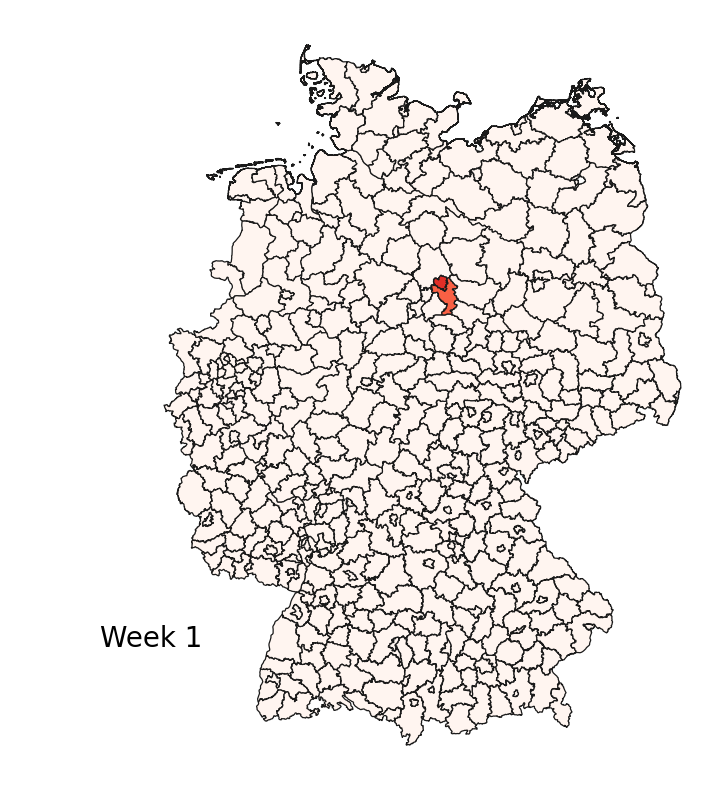

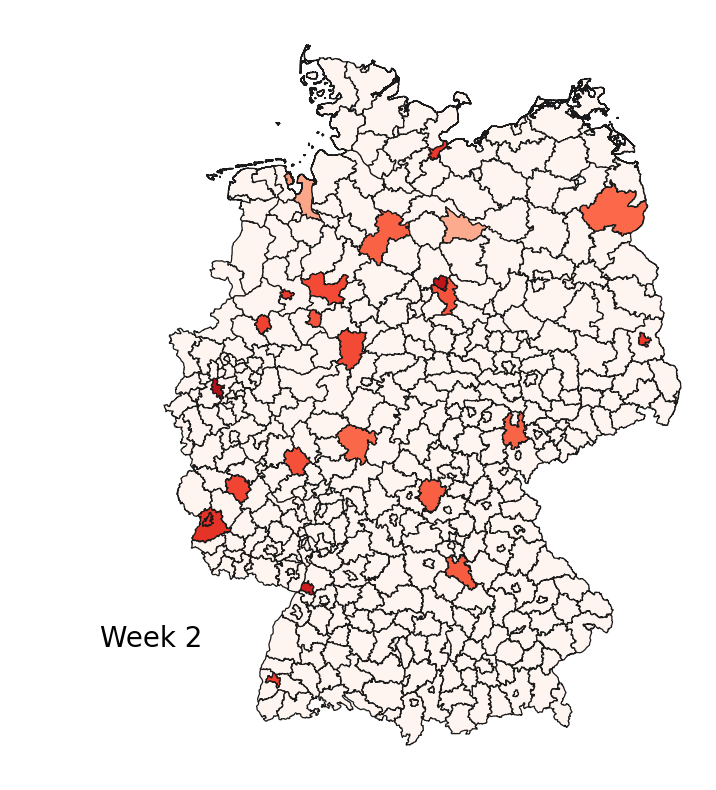

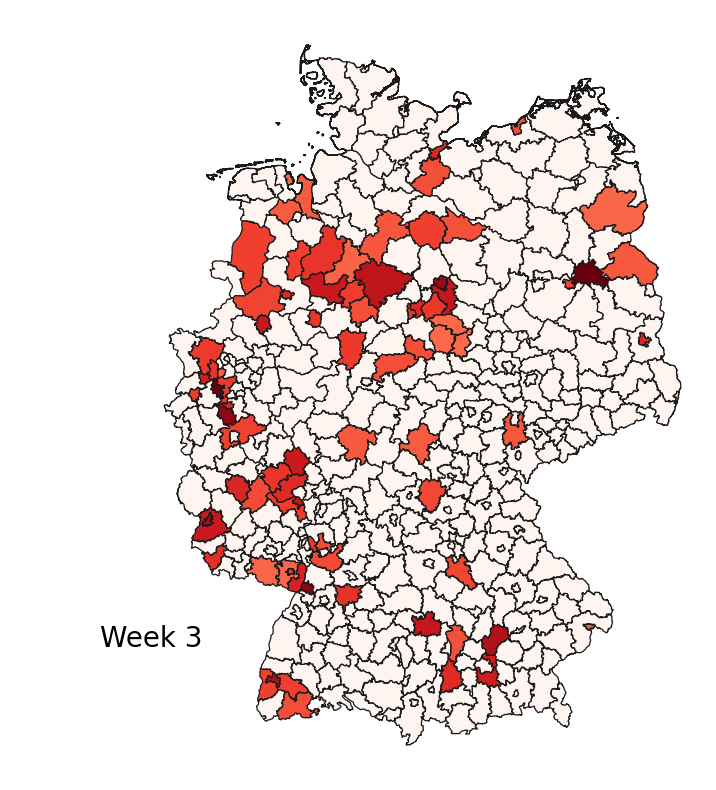

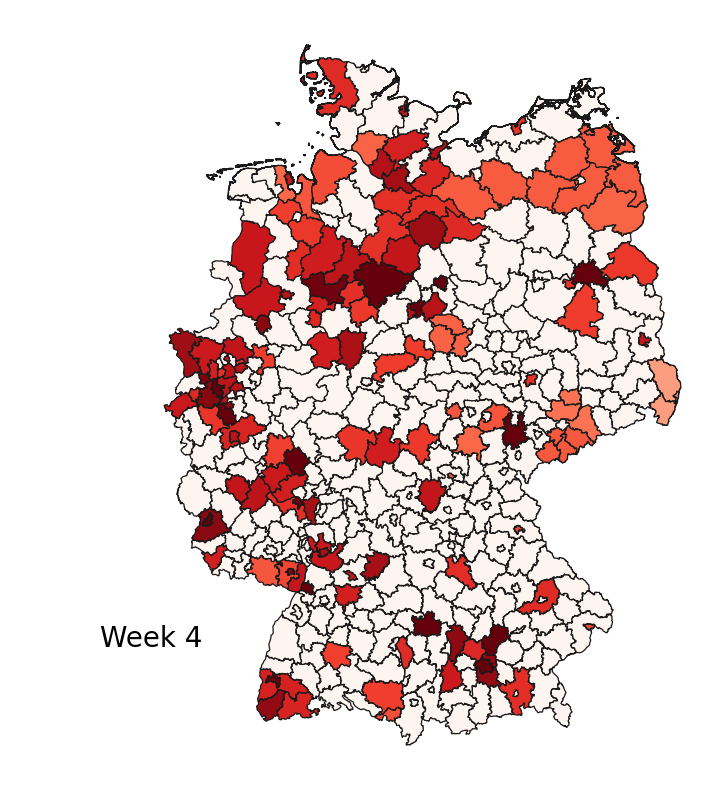

In [76]:
%%time
'''
Draws the covid19 incidence heatmap for 4 fixed weeks, only coloring weeks the above ruleset.

Other weeks can be selected by changing the bounds on the selected weeks in the initial if-clause
'''

# list of weeks (which are the column names at the moment)
list_of_weeks = df_covid_gis.iloc[:,1:103].columns.tolist()

# start the for loop to create one map per week
for week in list_of_weeks:
    
    # only include week of interest - can be changed to output more or different weeks
    if int(week)>30 and int(week)<35:
        norm1 = TwoSlopeNorm(vmin=0, vcenter=0.5, vmax=16) 
        # create map, UDPATE: added plt.Normalize to keep the legend range the same for all maps
        # color intensity depends on the magnitude of the incidence in that week
        fig = df_covid_gis.plot(column=week, cmap='Reds', figsize=(10,10), linewidth=0.9, rasterized=False, edgecolor='0.1',
    legend=False, norm=norm1)

        # remove axis of chart
        fig.axis('off')

        # (Optional) Add text describing each of the plots
        if int(week)==31:
            only_week ='Week 1'
        elif int(week)==32:
            only_week='Week 2'
        elif int(week)==33:
            only_week='Week 3'
        elif int(week)==34:
            only_week='Week 4'
            
        # position the annotation to the bottom left
        fig.annotate(only_week,
                xy=(0.1, .165), xycoords='figure fraction',
                horizontalalignment='left', verticalalignment='top',
                fontsize=20)

        # this will save the figure as pdf in the output path 
        filepath = os.path.join(res, only_week+'.pdf')
        chart = fig.get_figure()
        chart.savefig(filepath, dpi=100, bbox_inches='tight')